In [1]:
import pandas as pd
from pymatgen import core
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import src.preprocess_func as preprocess
import src.training_model as training
import src.plotting as plotting
import src.Variable_generator as vg

In [2]:
# filename = 'https://drive.google.com/uc?id=1-2Ia30pDDiRgof0FFinN4EQ-1BN24qld&export=download'
filename = 'srf/SM_FT_dataset.csv'
df = pd.read_csv(filename,index_col=0)

comps = [core.Composition(x) for x in df['Composition']]
dset = preprocess.data_generator(comps)
Training_sequences = dset.real_data # X_train
Elements_sequences = dset.elements #input elements sequence

properties_values = df.iloc[:,1:].values.astype('float32') # Y_train
scaler = StandardScaler() # Standard_scaler
properties_values_scaled = scaler.fit_transform(properties_values) # Scaled Y_train

# WcGAN

## Structure

In [3]:
import torch
import torch.nn as nn
import os


class Generator(nn.Module):

    def __init__(self, latent_dim, input_length, hidden_size):
        super(Generator, self).__init__()
        self.dense_layer1 = nn.Linear(int(latent_dim), int(hidden_size))
        self.dense_layer2 = nn.Linear(int(hidden_size), int(hidden_size))
        self.dense_layer3 = nn.Linear(int(hidden_size), int(hidden_size))
        self.dense_layer4 = nn.Linear(int(hidden_size), int(hidden_size))
        self.dense_layer5 = nn.Linear(int(hidden_size), int(input_length))
        self.activation = nn.LeakyReLU()

    def forward(self, x,property):
        x = torch.cat([x,property],1)
        x = self.activation(self.dense_layer1(x))
        x = self.activation(self.dense_layer2(x))
        x = self.activation(self.dense_layer3(x))
        x = self.activation(self.dense_layer4(x))
        x = self.dense_layer5(x)
        return torch.nn.Softmax(dim=-1)(x)


class Discriminator(nn.Module):
    def __init__(self, input_length, hidden_size):
        super(Discriminator, self).__init__()
        self.dense_layer1 = nn.Linear(int(input_length), int(hidden_size))
        self.dense_layer2 = nn.Linear(int(hidden_size), int(hidden_size))
        self.dense_layer3 = nn.Linear(int(hidden_size), int(hidden_size))
        self.dense_layer4 = nn.Linear(int(hidden_size), int(hidden_size))
        self.dense_layer5 = nn.Linear(int(hidden_size), 1)
        self.activation = nn.LeakyReLU()

    def forward(self, x, property):
        x = torch.cat([x,property],1)
        x = self.activation(self.dense_layer1(x))
        x = self.activation(self.dense_layer2(x))
        x = self.activation(self.dense_layer3(x))
        x = self.activation(self.dense_layer4(x))
        x = self.dense_layer5(x)
        return x

In [4]:
surrogate_model=training.training_surrogate_ANN(Training_sequences,properties_values_scaled)

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 100, Loss:0.8500775098800659
epoch: 200, Loss:0.25712698698043823
epoch: 300, Loss:0.12917037308216095
epoch: 400, Loss:0.11601553857326508
epoch: 500, Loss:0.09371211379766464
epoch: 600, Loss:0.05439404770731926
epoch: 700, Loss:0.021689463406801224
epoch: 800, Loss:0.011522161774337292
epoch: 900, Loss:0.007899677380919456
epoch: 1000, Loss:0.005724471062421799
epoch: 1100, Loss:0.004289987962692976
epoch: 1200, Loss:0.003337132278829813
epoch: 1300, Loss:0.0027059167623519897
epoch: 1400, Loss:0.0022675716318190098
epoch: 1500, Loss:0.0019492566352710128
epoch: 1600, Loss:0.001717897830531001
epoch: 1700, Loss:0.001555255614221096
epoch: 1800, Loss:0.0014411219162866473
epoch: 1900, Loss:0.0013625486753880978
epoch: 2000, Loss:0.00130635523237288
******Training ANN completed*****


In [5]:
from sklearn.neighbors import KernelDensity
class WcGAN():
    def __init__(self,dset,properties_values_scaled,surrogate_model):
        self.batch_size = 500
        self.minibatch_size = self.batch_size
        # self.training_steps = 5000
        self.num_iterations = int(1e3)
        self.log_interval = self.num_iterations/10

        self.dset = dset
        self.properties_values_scaled = properties_values_scaled
        self.surrogate_model = surrogate_model
        # Models
        z = 10
        conditions = 2
        g_inp =  z+conditions
        input_length, latent_dim, hidden_size = (22, g_inp, g_inp*2)
        self.generator = Generator(latent_dim, input_length, hidden_size) #(12,22,44)
        self.discriminator = Discriminator(input_length+conditions, hidden_size) #(24,44)

        # Optimizers
        beta = (0.5,0.99)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=2e-4,betas=beta)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4,betas=beta) #RMSprop

        self.d_steps = 1
        self.g_steps = 1


        self.kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(self.properties_values_scaled)

        self.samples_real = np.zeros((10,self.minibatch_size,2))
        self.samples_fake = np.zeros((10,self.minibatch_size,2))

    def noise_sampler(self,N, z_dim):
        return np.random.normal(size=[N, z_dim]).astype('float32')

    def train(self):

        sample_time = 0
        for it in tqdm(range(self.num_iterations)):
            # d_infos = []
            for d_index in range(self.d_steps):
                self.d_loop()
                #d_infos.append(d_info)
            #d_infos = np.mean(d_infos, 0)
            #d_real_loss, d_fake_loss = d_infos
            
            #g_infos = []
            for g_index in range(self.g_steps):
                self.g_loop()
                #g_infos.append(g_info)
            #g_infos = np.mean(g_infos)
            #g_loss = g_infos
            
            if (it + 1) % self.log_interval == 0:
                g_fake_data,true_data = self.g_sample()
                self.samples_real[sample_time] = true_data
                self.samples_fake[sample_time] = self.surrogate_model(torch.tensor(g_fake_data)).detach().numpy()
                sample_time+=1

    
        
    def d_loop(self):
        self.discriminator_optimizer.zero_grad()

        train_data, train_idx = self.dset.sample(self.batch_size)
        train_prop = self.properties_values_scaled[train_idx]
        d_real_data = torch.from_numpy(train_data)
        d_real_prop = torch.from_numpy(train_prop)

        true_discriminator_out = self.discriminator(d_real_data,d_real_prop)
        d_gen_input = torch.from_numpy(self.noise_sampler(self.batch_size, 10)) #z=10
        d_gen_prop = self.kde.sample(self.batch_size).astype('float32')
        d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 

        generated_data = self.generator(d_gen_input,d_gen_prop)
        # generated_data = self.generator(d_gen_input,d_real_prop)

        generator_discriminator_out = self.discriminator(generated_data.detach(),d_gen_prop)
        # generator_discriminator_out = self.discriminator(generated_data.detach(),d_real_prop)

        discriminator_loss = (torch.mean(generator_discriminator_out) - torch.mean(true_discriminator_out))
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        for p in self.discriminator.parameters():
            p.data.clamp_(-0.5, 0.5)
            
    def g_loop(self):
        self.generator_optimizer.zero_grad()

        d_gen_input = torch.from_numpy(self.noise_sampler(self.batch_size, 10)) # z=10
        d_gen_prop = self.kde.sample(self.batch_size).astype('float32')
        d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
        generated_data = self.generator(d_gen_input,d_gen_prop)
        generator_discriminator_out = self.discriminator(generated_data,d_gen_prop)
        generator_loss =  -torch.mean(generator_discriminator_out)
        generator_loss.backward()
        self.generator_optimizer.step()
    
    def g_sample(self):
        with torch.no_grad():
            gen_input = torch.from_numpy(self.noise_sampler(self.minibatch_size, 10))
            #prop_input = np.random.uniform(max,min,(minibatch_size,prop_dim)).astype('float32')
            prop_input = self.kde.sample(self.minibatch_size).astype('float32')
            prop_input = torch.from_numpy(prop_input)
            g_fake_data = self.generator(gen_input,prop_input)
            return g_fake_data.detach().numpy(),prop_input

In [6]:
WcGAN = WcGAN(dset,properties_values_scaled,surrogate_model)
WcGAN.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
import matplotlib.colors
colorformat = {
    "background":"#FFFFFF",
    "text":"#140812",
    "Highlight":"#730000",
    "bar":"#333F67",
    "line":"#223542"
    }
order=[
    "First",
    "Second",
    "Third",
    "Forth",
    "Fifth",
    "Sixth",
    "Seventh",
    "Eighth",
    "Ninth",
    "Tenth"
]
grid_style = (0, (5, 5))

cmap_format = matplotlib.colors.LinearSegmentedColormap.from_list("",[colorformat["background"],colorformat["bar"]])

def compare_different(real,fake,scaler):
    """Use for GAN to compare the difference"""
    fig,axes = plt.subplots(10,1,figsize=(5,50),constrained_layout=True)
    fig.set_facecolor(colorformat["background"])
    fig.suptitle("WcGAN accuracy",color=colorformat["text"],fontsize=15)
    for i in range(10):
        data = scaler.inverse_transform(real[i])-scaler.inverse_transform(fake[i])
        axes[i].hist2d(data[:,0],data[:,1],bins=[30,10],cmap=cmap_format) #Blues
        axes[i].set_xlim(-50,50)
        axes[i].set_ylim(-50,50)
        axes[i].set_xlabel("toughness")
        axes[i].set_ylabel("shear modulus")
        axes[i].set_title("epoch = {}".format(i))
        axes[i].set_facecolor(colorformat["background"])
        axes[i].grid(visible = True)

    return fig

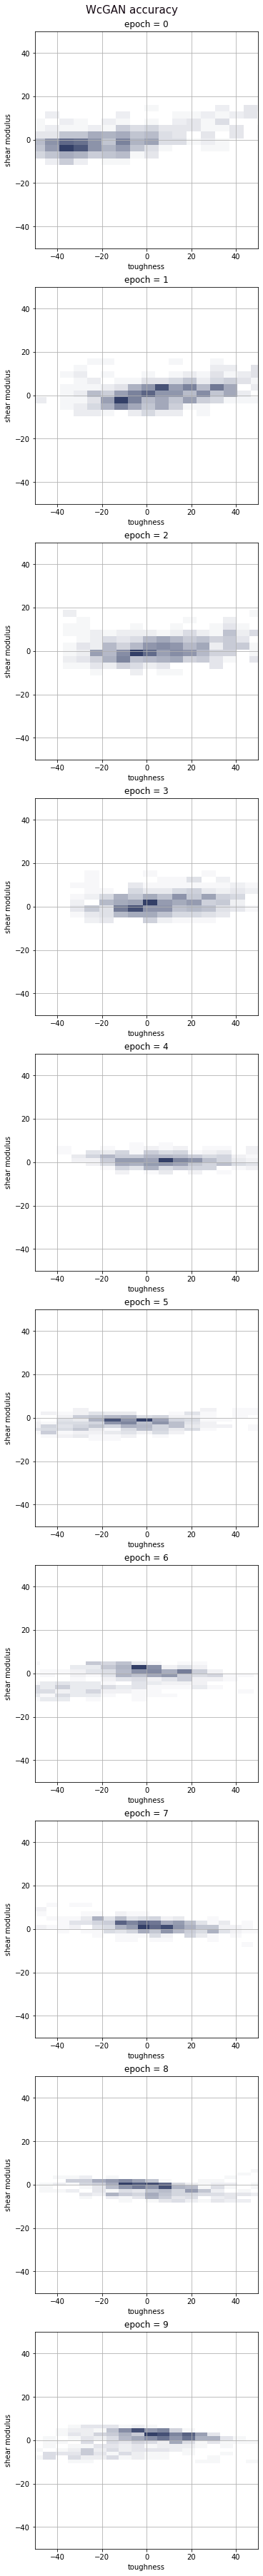

In [8]:
_ = compare_different(WcGAN.samples_real,WcGAN.samples_fake,scaler)

In [9]:
targets = torch.from_numpy(scaler.transform(vg.create_target_ys(10,50,10))).float()
noise = torch.from_numpy(WcGAN.noise_sampler(10,10)).float()
gen = WcGAN.generator(noise,targets)
res = surrogate_model(gen)

In [10]:
scaler.inverse_transform(res.detach().numpy())

array([[35.845325, 12.285635],
       [34.880383, 12.376831],
       [29.664091, 14.345655],
       [34.917286, 16.72867 ],
       [34.068066, 11.543357],
       [35.400948, 12.699993],
       [35.607994, 13.76929 ],
       [33.758232, 12.469219],
       [33.249252, 12.542051],
       [29.33444 , 14.903958]], dtype=float32)

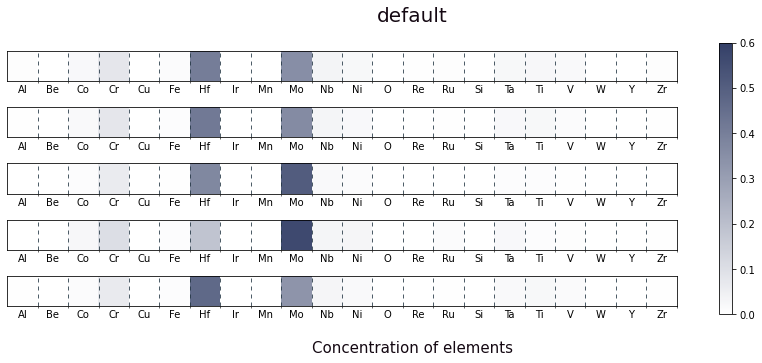

In [11]:
_ = plotting.component_variance_plot(gen.detach().numpy(),dset,interval = 1)

In [12]:
def create_target_ys(rows,toughness_value,shear_value):
  """This function is the function to create sets(rows) of y label"""
  # example: rows = 2000
  target_ys = np.zeros((rows,2))
  for i in range(rows):
    target_ys[i] = np.array([toughness_value,shear_value])
  return target_ys

def preprocess_variance_map_GAN(properties_values,Scaler,cGAN,surrogate_model,interpolation = 5):
  #latent code setting
  latent_code = cGAN.noise_sampler(2000,10)
  latent_code = torch.tensor(latent_code).float()

  # conditions setting
  input_toughness = np.linspace(properties_values[:,0].min(),properties_values[:,0].max(),interpolation)
  input_shear = np.linspace(properties_values[:,1].max(),properties_values[:,1].min(),interpolation)

  surr_value = np.zeros((interpolation*interpolation,2000,2))
  count = 0
  for i in range (interpolation):
      for j in range(interpolation):
          cond = create_target_ys(2000,input_toughness[i],input_shear[j])
          cond = Scaler.transform(cond)
          cond = torch.tensor(cond).float()
          recipes = cGAN.generator(latent_code,cond)
          surr_value[count] = surrogate_model(recipes).detach().numpy()
          surr_value[count] = Scaler.inverse_transform(surr_value[count])
          count += 1
  return surr_value,[input_toughness,input_shear]

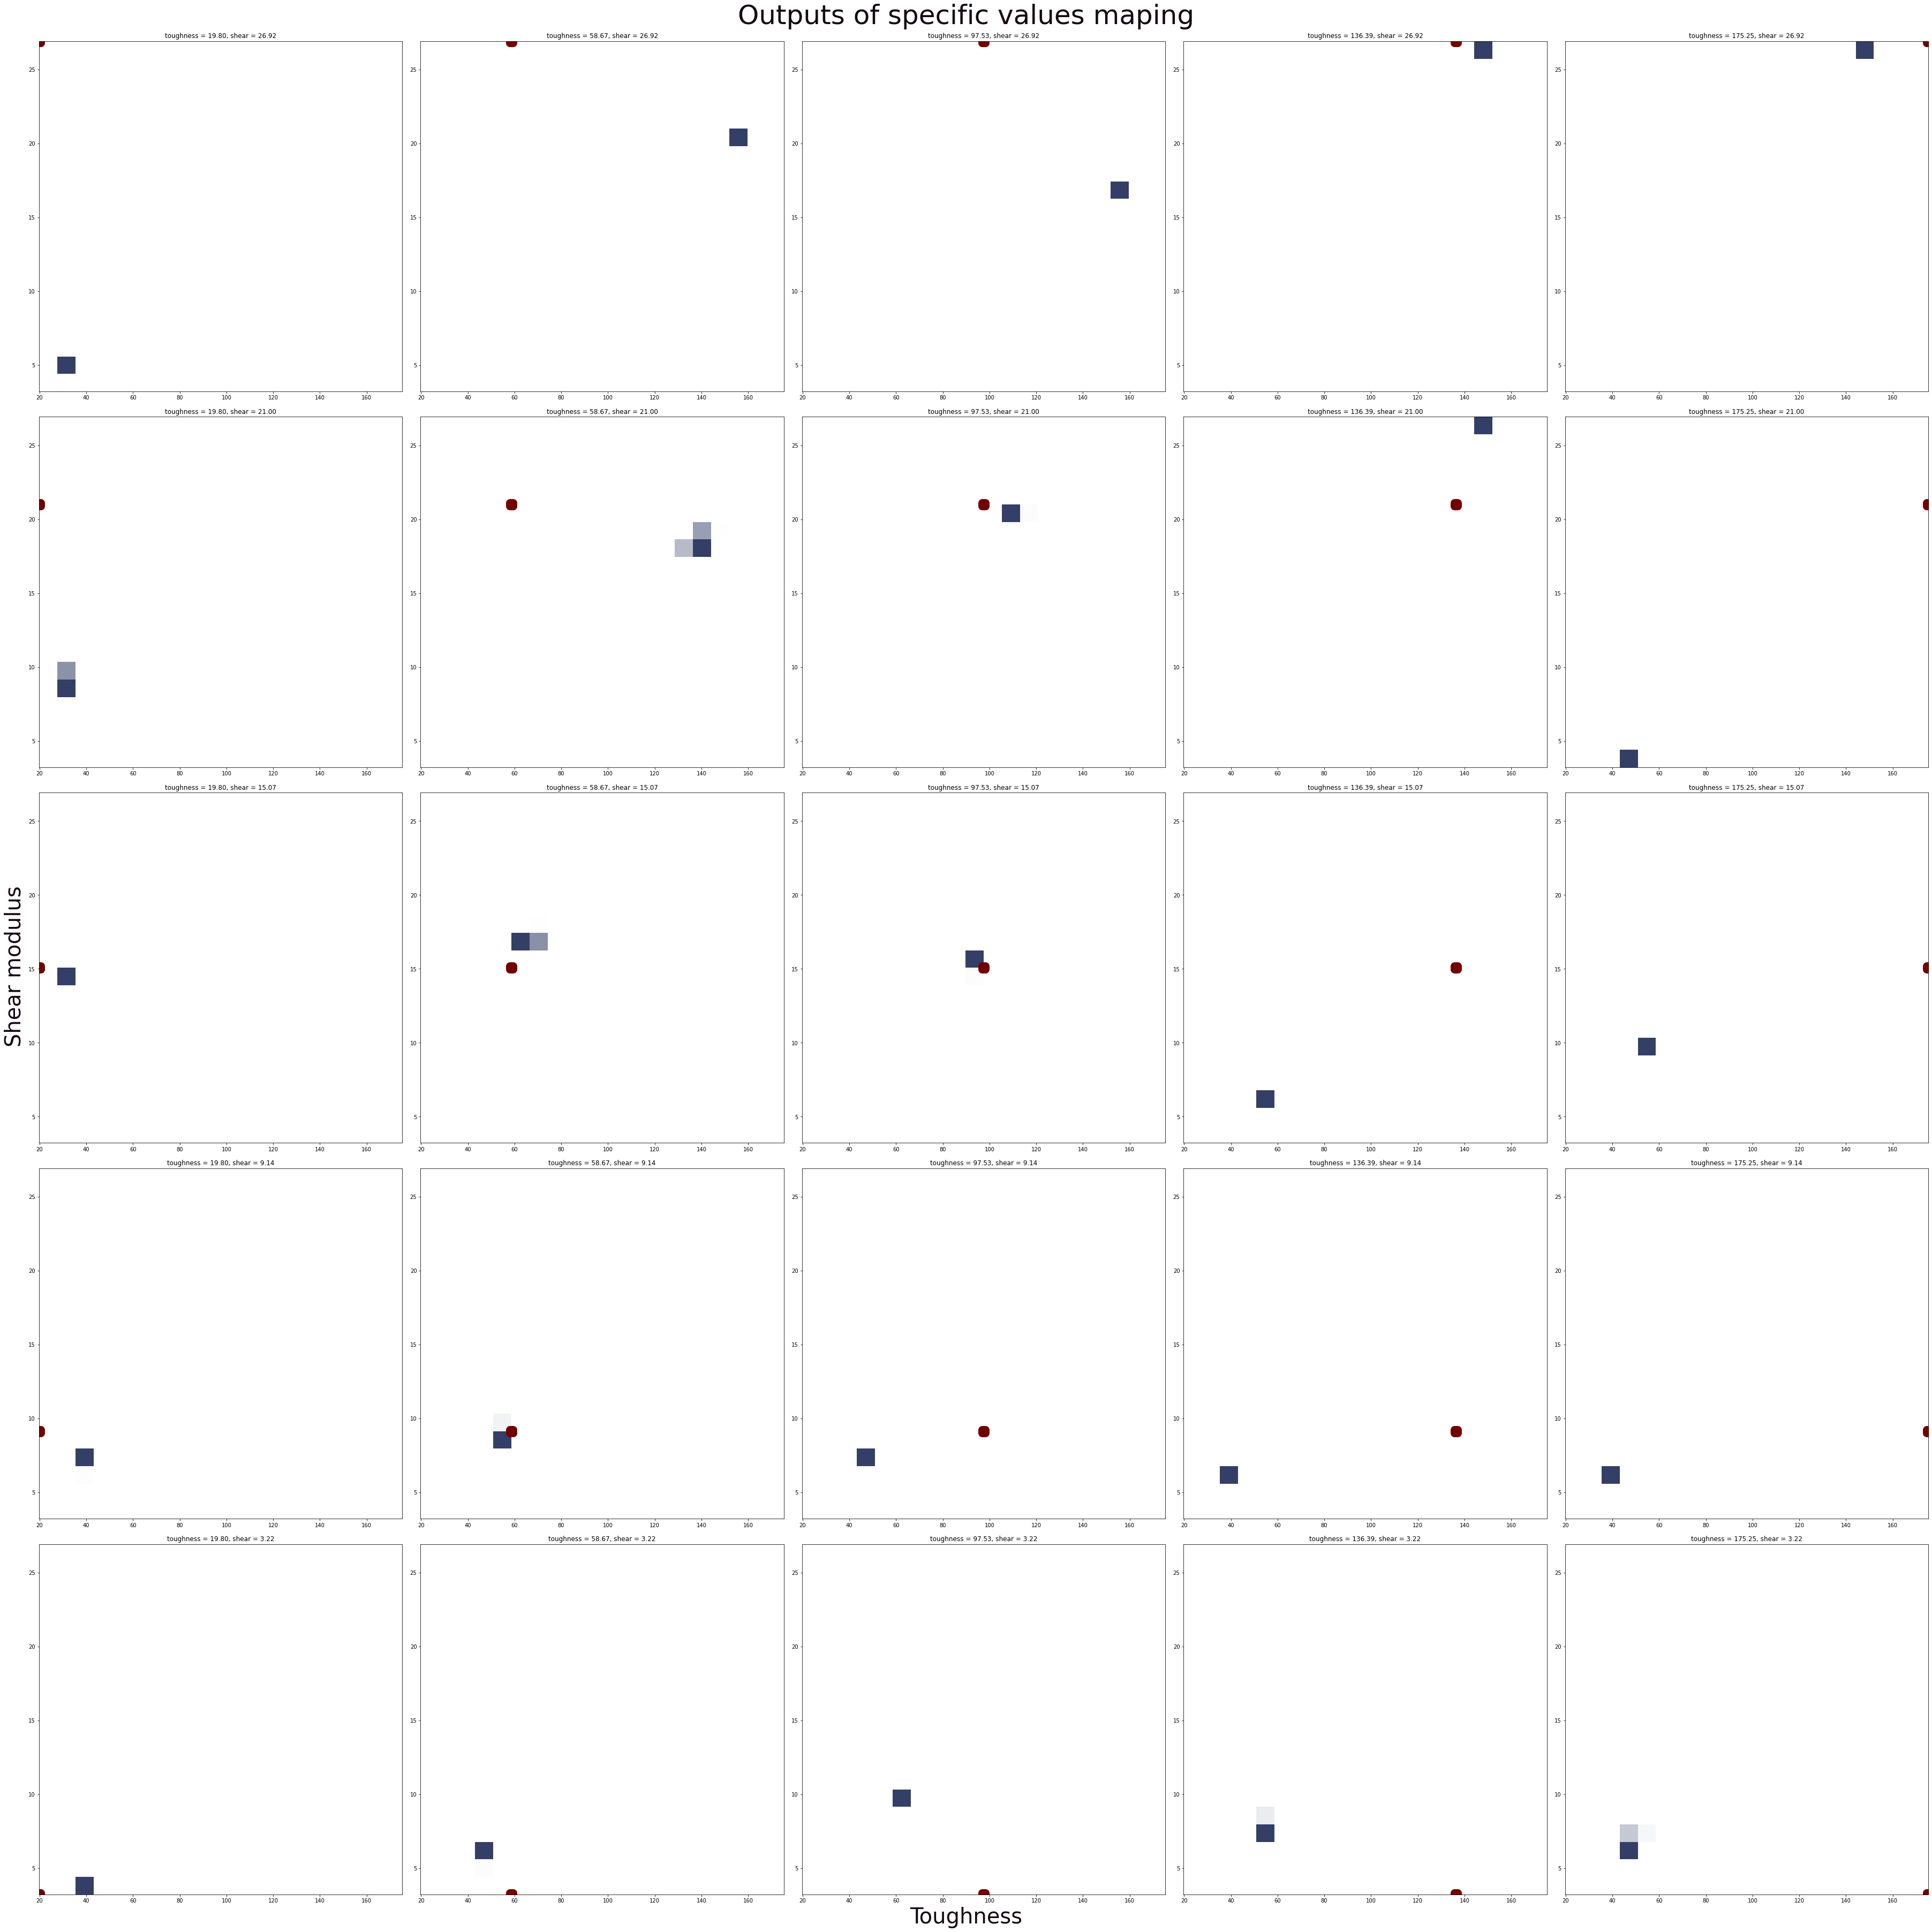

In [46]:
def variance_map(forim,inter_cond,interpolation=5):
    fig,axes = plt.subplots(interpolation,interpolation,figsize=(50,50),constrained_layout=True)
    fig.set_facecolor(colorformat["background"])
    fig.supxlabel("Toughness",color=colorformat["text"],fontsize=40)
    fig.supylabel("Shear modulus",color=colorformat["text"],fontsize=40)
    fig.suptitle("Outputs of specific values maping",color=colorformat["text"],fontsize=50)
    # forim,inter_cond = preprocess_variance_map(properties_values,scaler,WcGAN,surrogate_model)
    count = 0
    for i in range(interpolation): #shear
        for j in range(interpolation): #toughness
            axes[j][i].hist2d(forim[count,:,0],forim[count,:,1],bins=20,range=np.array([[inter_cond[0].min(),inter_cond[0].max()],[inter_cond[1].min(),inter_cond[1].max()]]),cmap=cmap_format) #Blues
            axes[j][i].scatter(inter_cond[0][i],inter_cond[1][j],marker = 's',color =colorformat["Highlight"],linewidths = 15)
            axes[j][i].set_title('toughness = {t:.2f}, shear = {s:.2f}'.format(t=inter_cond[0][i],s=inter_cond[1][j]))
            count += 1
    return fig

forim,inter_cond = preprocess_variance_map_GAN(properties_values,scaler,WcGAN,surrogate_model)
_ = variance_map(forim,inter_cond)

In [9]:
collected_data,collected_conds = vg.preprocess_violinplot_GAN(properties_values,scaler,WcGAN,surrogate_model)
_ = plotting.violin_plot(collected_data,collected_conds)

In [59]:
def preprocess_violinplot_GAN(properties_values,Scaler,cGAN,surrogate_model,interpolation=20,latent_dim = 10):
    # make latentcode
    latent_code = cGAN.noise_sampler(2000,10)
    latent_code = torch.tensor(latent_code).float()

    #make input conditions
    input_toughness = np.linspace(properties_values[:,0].min(),properties_values[:,0].max(),20)
    input_shear = np.linspace(properties_values[:,1].min(),properties_values[:,1].max(),20)

    surr_value = np.zeros((2,2000,interpolation))

    for i in range(20):
        cond = create_target_ys(2000,input_toughness[i],input_shear[i])
        cond = Scaler.transform(cond)
        cond = torch.tensor(cond).float()
        recipes = cGAN.generator(latent_code,cond)
        surr_res = Scaler.inverse_transform(surrogate_model(recipes).detach().numpy())
        surr_value[0,:,i] = surr_res[:,0]
        surr_value[1,:,i] = surr_res[:,1]
        # surr_value[i] = Scaler.inverse_transform(surr_value[i])
    return surr_value,[input_toughness,input_shear]

In [68]:
def violin_plot(collected_data,collected_conds):
  #collected data in shape with (2, 2000, 20)
  #pick shear modulus or toughness
  #Over_value can offer the way to explore the properties out of the range
  #Violin plot (data,objects) (2000,20)

  properties_name=["toughness","shear modulus"]
  #calculate mean
  def calculate_mean(outputproperties):
    meandata = np.zeros((2,20))
    for i in range(20):
      meandata[0][i]= outputproperties[0,:,i].mean()
      meandata[1][i]= outputproperties[1,:,i].mean()
    return meandata

  mean_data = calculate_mean(collected_data)

  #Plotting violin plot
  fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(200,100),constrained_layout=True)
  fig.set_facecolor(colorformat["background"])
  # fig.suptitle("Outputs of specific values maping",color=colorformat["text"],fontsize=200)
  for i in range(2):
    if i == 0:
      w=3
    else:
      w=0.5 
    violin = axes[i].violinplot(collected_data[i],collected_conds[i],widths=w,showextrema=False,showmeans=False)
    for pc in violin['bodies']:
      pc.set_facecolor(colorformat['bar'])
      pc.set_edgecolor(colorformat['line'])
      pc.set_alpha(1)
    axes[i].grid(visible=True,linewidth=2)
    axes[i].set_facecolor(colorformat["background"])
    axes[i].set_xlabel("setting",fontsize=120)
    axes[i].set_ylabel("generated and expected",fontsize=120)
    axes[i].set_title(properties_name[i],fontsize=150)
    axes[i].plot(collected_conds[i],mean_data[i],c=colorformat["Highlight"],linewidth=20,label="generated")
    axes[i].plot(collected_conds[i],collected_conds[i],"--",c=colorformat["Highlight"],linewidth=20,label="expected")
    axes[i].legend(fontsize=150,loc=2)

  return fig

In [69]:
collected_data,collected_conds = preprocess_violinplot_GAN(properties_values,scaler,WcGAN,surrogate_model)
_ = violin_plot(collected_data,collected_conds)